In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp /content/drive/MyDrive/CollabData/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

#Import Library

In [ ]:
!pip install lazypredict
!pip install optuna
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import missingno
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler , PowerTransformer , RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split , cross_val_score , KFold

from lazypredict.Supervised import LazyRegressor
import optuna
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import  ExtraTreesRegressor , StackingRegressor , GradientBoostingRegressor

import lightgbm
import xgboost as xgb
import catboost

from IPython.display import display

#Datasets

## Download Datasets

In [ ]:
! kaggle competitions download home-data-for-ml-course

home-data-for-ml-course.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip home-data-for-ml-course.zip # Any Prediction type Competition

Archive:  home-data-for-ml-course.zip
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: sample_submission.csv.gz  
  inflating: test.csv                
  inflating: test.csv.gz             
  inflating: train.csv               
  inflating: train.csv.gz            


## Load Datasets

In [ ]:
# LOAD DATAFRAME

train_data = pd.read_table(r'/content/train.csv', sep=',')
test_data  = pd.read_table(r'/content/test.csv', sep=',')

print(f'Shape of Train data : {train_data.shape}')
print(f'Shape of Test data  : {test_data.shape}')

Shape of Train data : (1460, 81)
Shape of Test data  : (1459, 80)


In [ ]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#EDA

##Dataset Information

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [ ]:
combined_data = pd.concat((train_data, test_data), axis=0)

combined_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.00
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.00
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.00
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.00
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.00,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,2916,160,RM,21.00,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,2917,20,RL,160.00,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,2918,85,RL,62.00,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


### Null Value

In [ ]:
train_empty = train_data.isna().sum()

In [ ]:
test_empty = test_data.isna().sum()

In [ ]:
train_empty.drop(labels='SalePrice', axis=0, inplace=True)

In [ ]:
train_empty.compare(test_empty).sort_values(by='self', ascending=False)

,self,other
PoolQC,1453.00,1456.00
MiscFeature,1406.00,1408.00
Alley,1369.00,1352.00
Fence,1179.00,1169.00
MasVnrType,872.00,894.00
FireplaceQu,690.00,730.00
LotFrontage,259.00,227.00
GarageType,81.00,76.00
GarageYrBlt,81.00,78.00
GarageFinish,81.00,78.00


###Percentage Comparison

In [ ]:
# Convert into Dataframe
missing_value = pd.DataFrame(data=train_data.isna().sum(), index=train_data.columns, columns=['missing'])

# Add 'Percentage' Column
missing_value['Percentage'] = (missing_value['missing'] / 1460) * 100

# Sort By Descending
missing_value = missing_value.sort_values(by='Percentage',ascending=False)

missing_value.head(20)

,missing,Percentage
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55


###Null Visualization

(<Axes: >, <Axes: >)

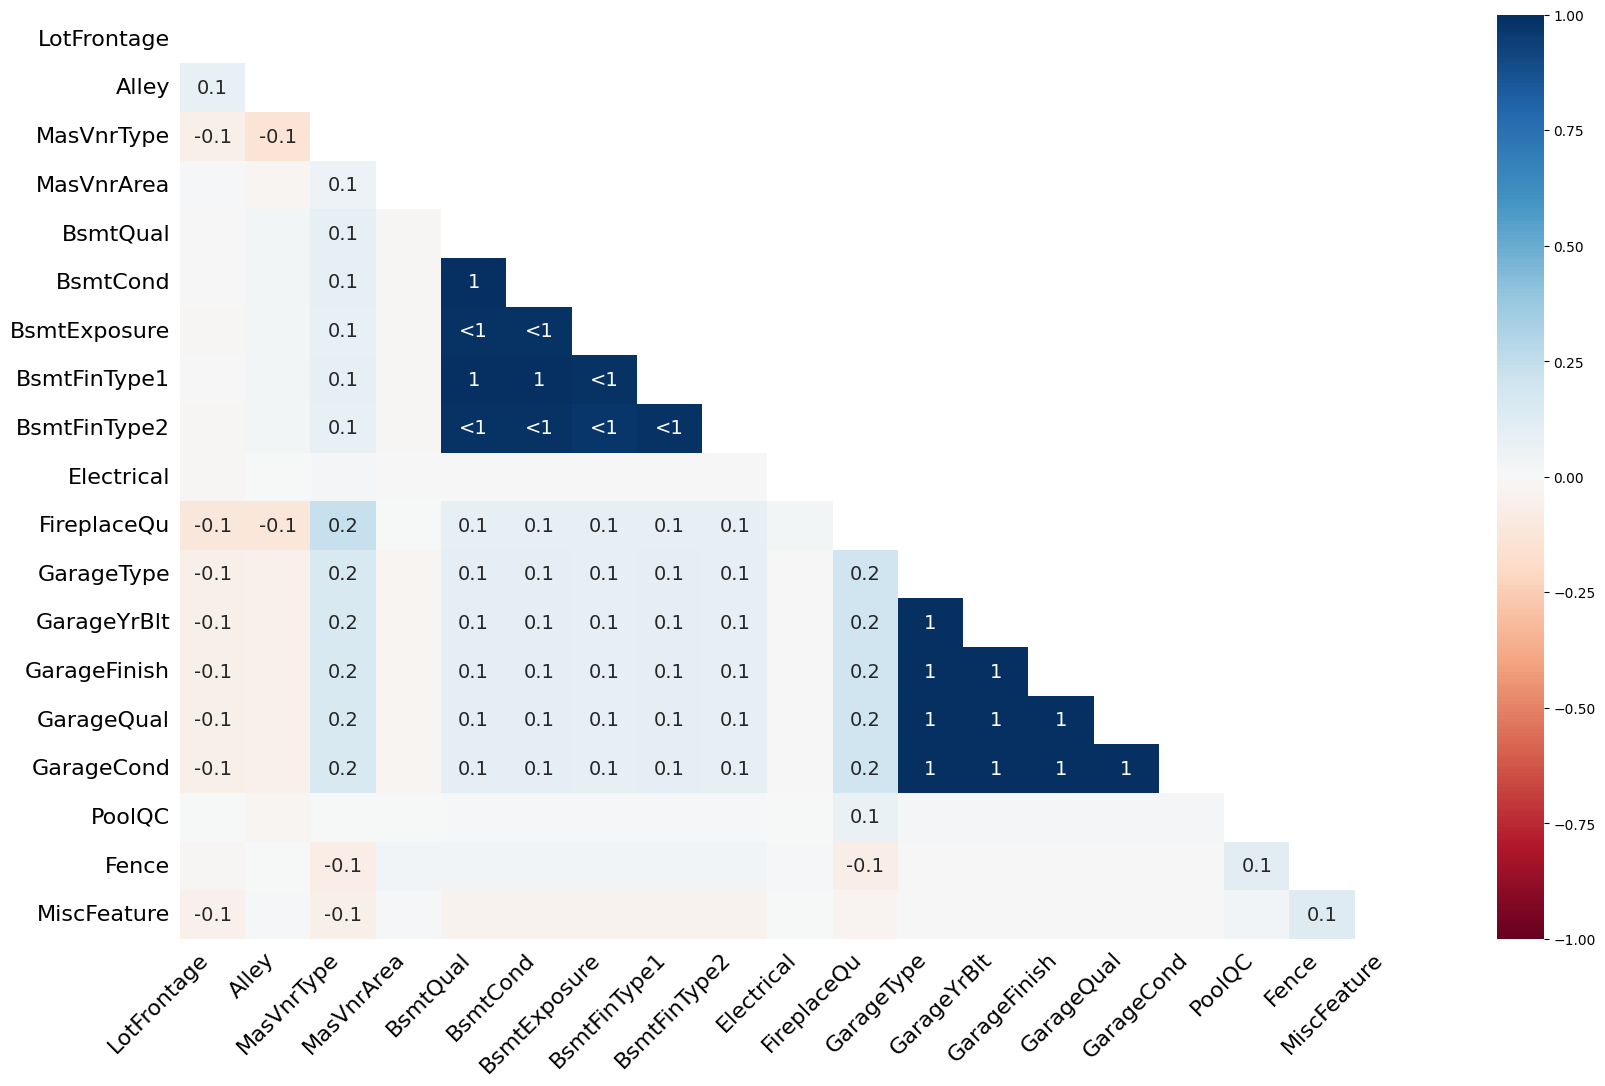

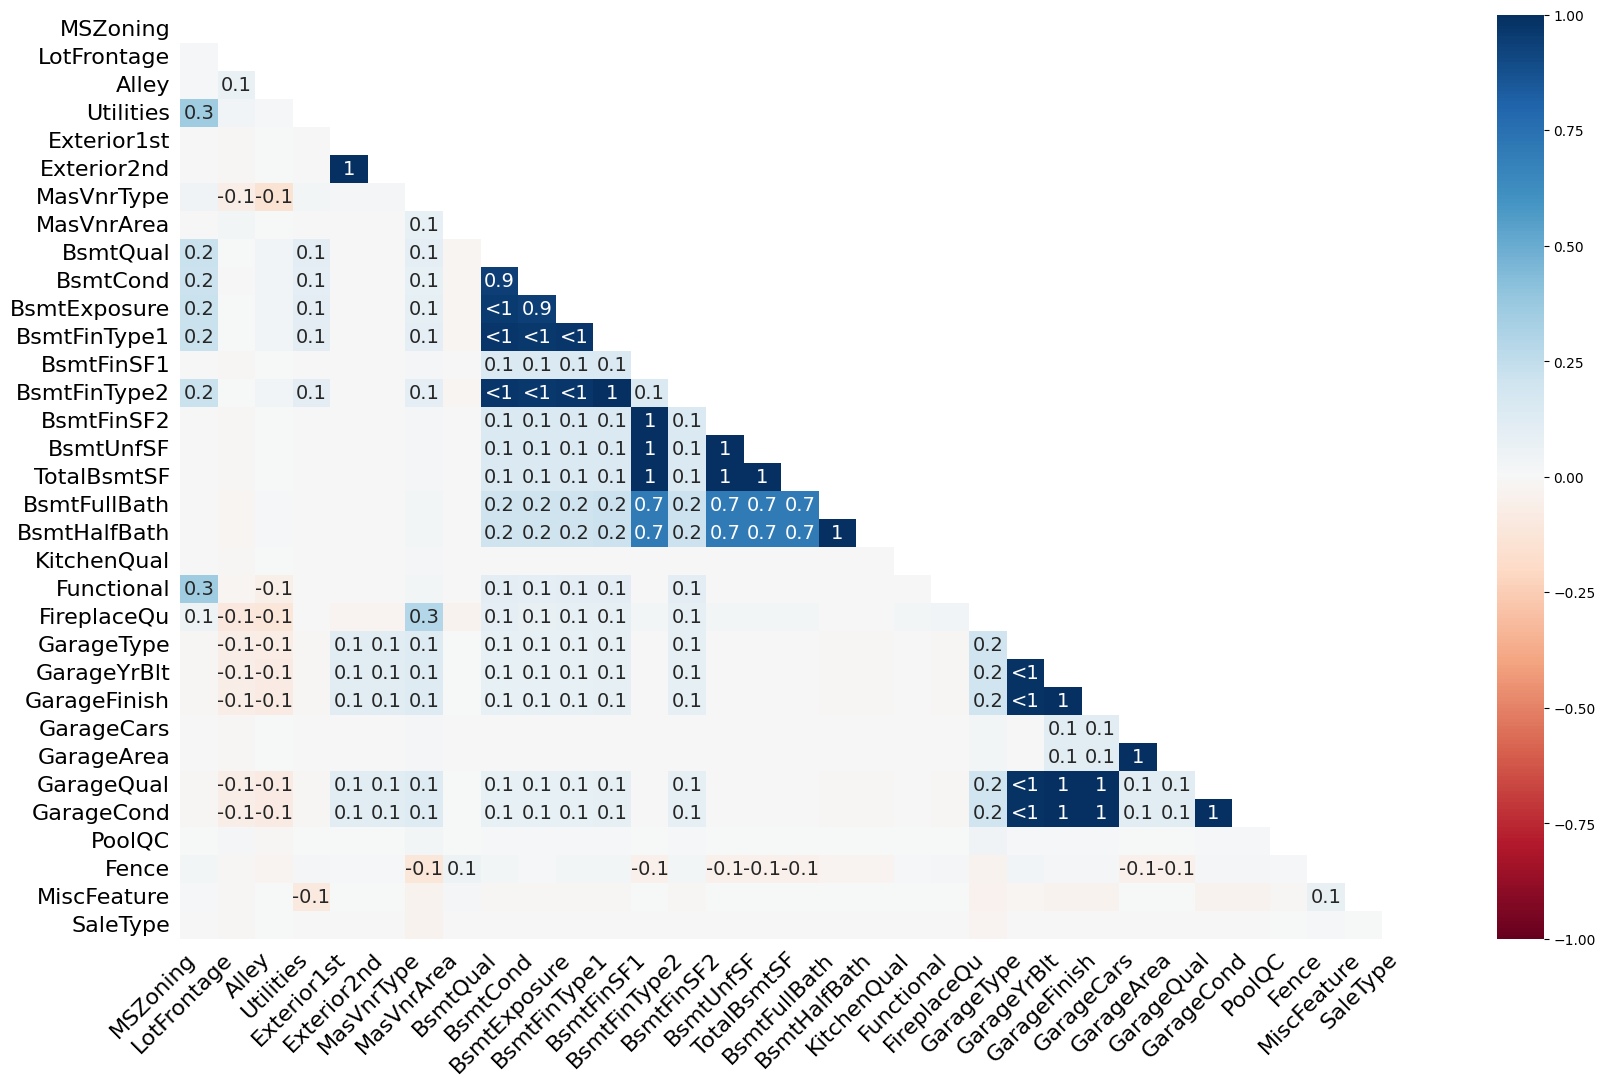

In [ ]:
missingno.heatmap(df= train_data) , missingno.heatmap(df= test_data)

###Data Distribution

In [ ]:
categorical_feature = train_data.select_dtypes(include='object').columns.tolist()

numerical_feature   = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_feature   = [col for col in numerical_feature if col != 'Id' and col != 'SalePrice']

discrete_feature    = [col for col in numerical_feature if len(train_data[col].unique()) < 25]
continuous_feature  = [col for col in numerical_feature if col not in discrete_feature]

print(f'Number of Categorical Feature : {len(categorical_feature)}')
print(f'Number of Numerical Feature   : {len(numerical_feature)}')
print(f'Number of Discrete Feature    : {len(discrete_feature)}')
print(f'Number of Continous Feature   : {len(continuous_feature)}')

Number of Categorical Feature : 43
Number of Numerical Feature   : 36
Number of Discrete Feature    : 18
Number of Continous Feature   : 18


###Comparison for Categorical Feature

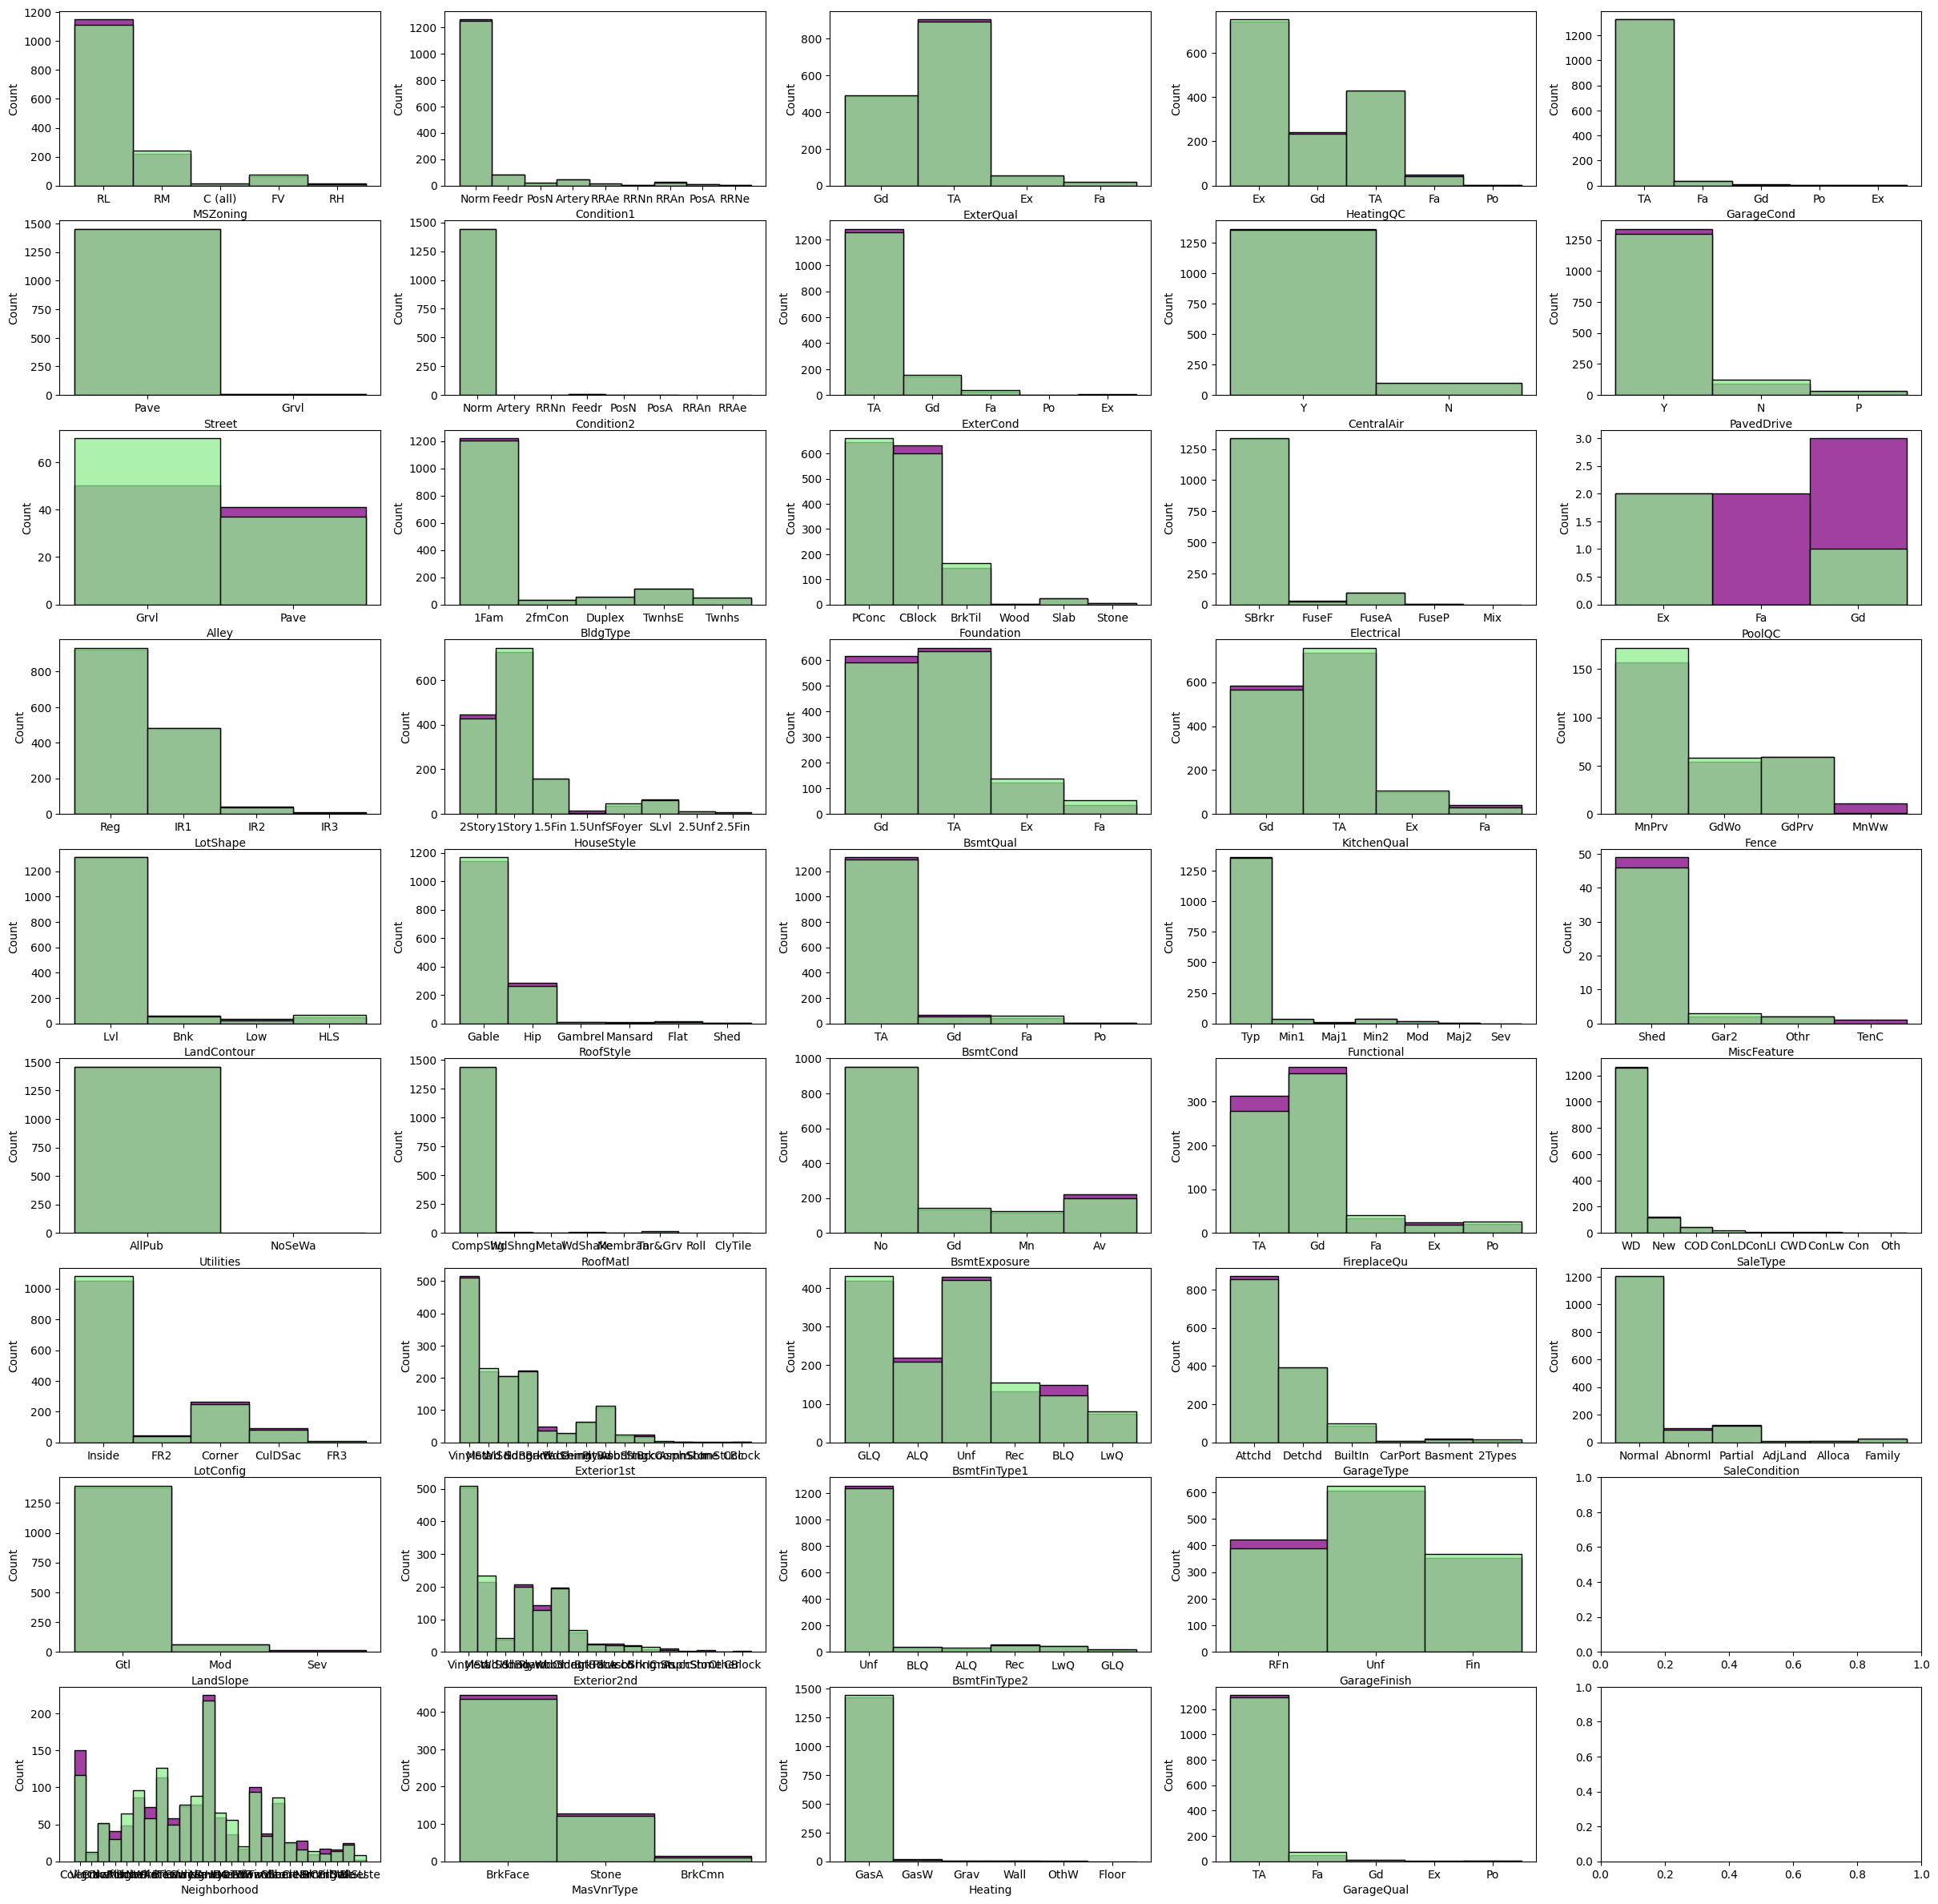

In [ ]:
fig , axes = plt.subplots(nrows= 9, ncols=5, figsize=(30,30))

for i, feature in enumerate(categorical_feature):
    sns.histplot(data= train_data, x=feature, ax=axes[i%9, i//9], color='purple')   # DISTRIBUTION FOR TRAIN DATA
    sns.histplot(data= test_data, x=feature, ax=axes[i%9, i//9], color='lightgreen')  # DISTRIBUTION FOR TEST DATA

The data distribution between training data and test data is almost the same, except for PoolQC

Some Feature have Dominants Label ,So we drop features that are only dominated by 1 label, such as RoofMatl, Street, GarageCond, Condition2, Utilities, Heating.

###Comparison Discrete Feature

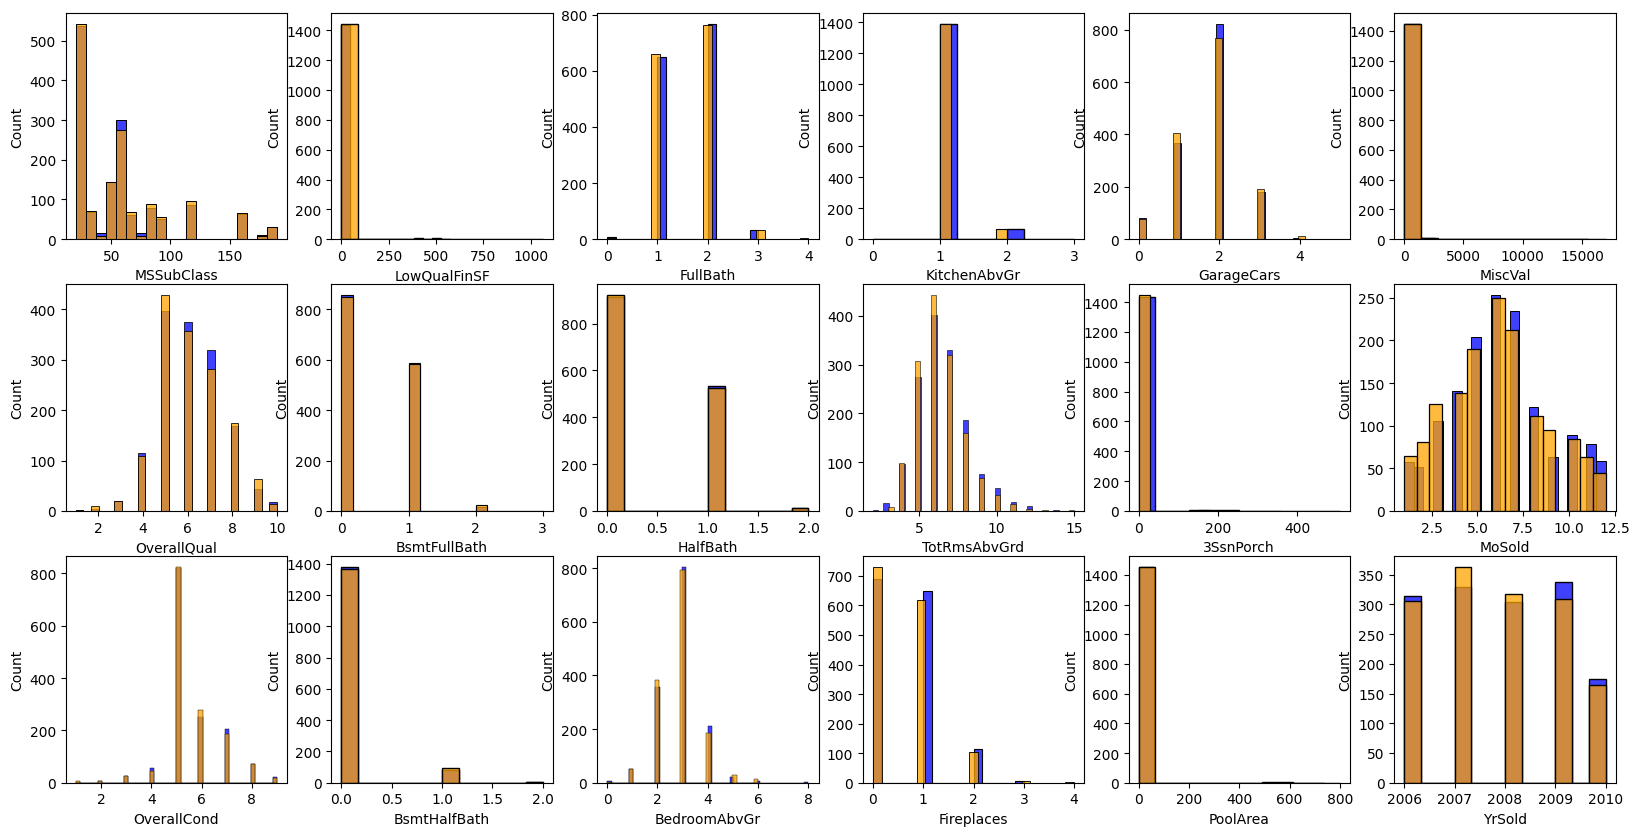

In [ ]:
fig , axes = plt.subplots(nrows=3, ncols=6, figsize=(20,10))

for i , feature in enumerate(discrete_feature):
    sns.histplot(data= train_data, x= feature, ax=axes[i%3, i//3], color='blue')
    sns.histplot(data= test_data,  x= feature, ax=axes[i%3, i//3], color='orange')

plt.show()

Some features are dominated by 0 values, such as LowQualFinSF, MiscVal, 3SsnPorch, PoolArea. I will drop those columns

###Comparison Continuous Feature

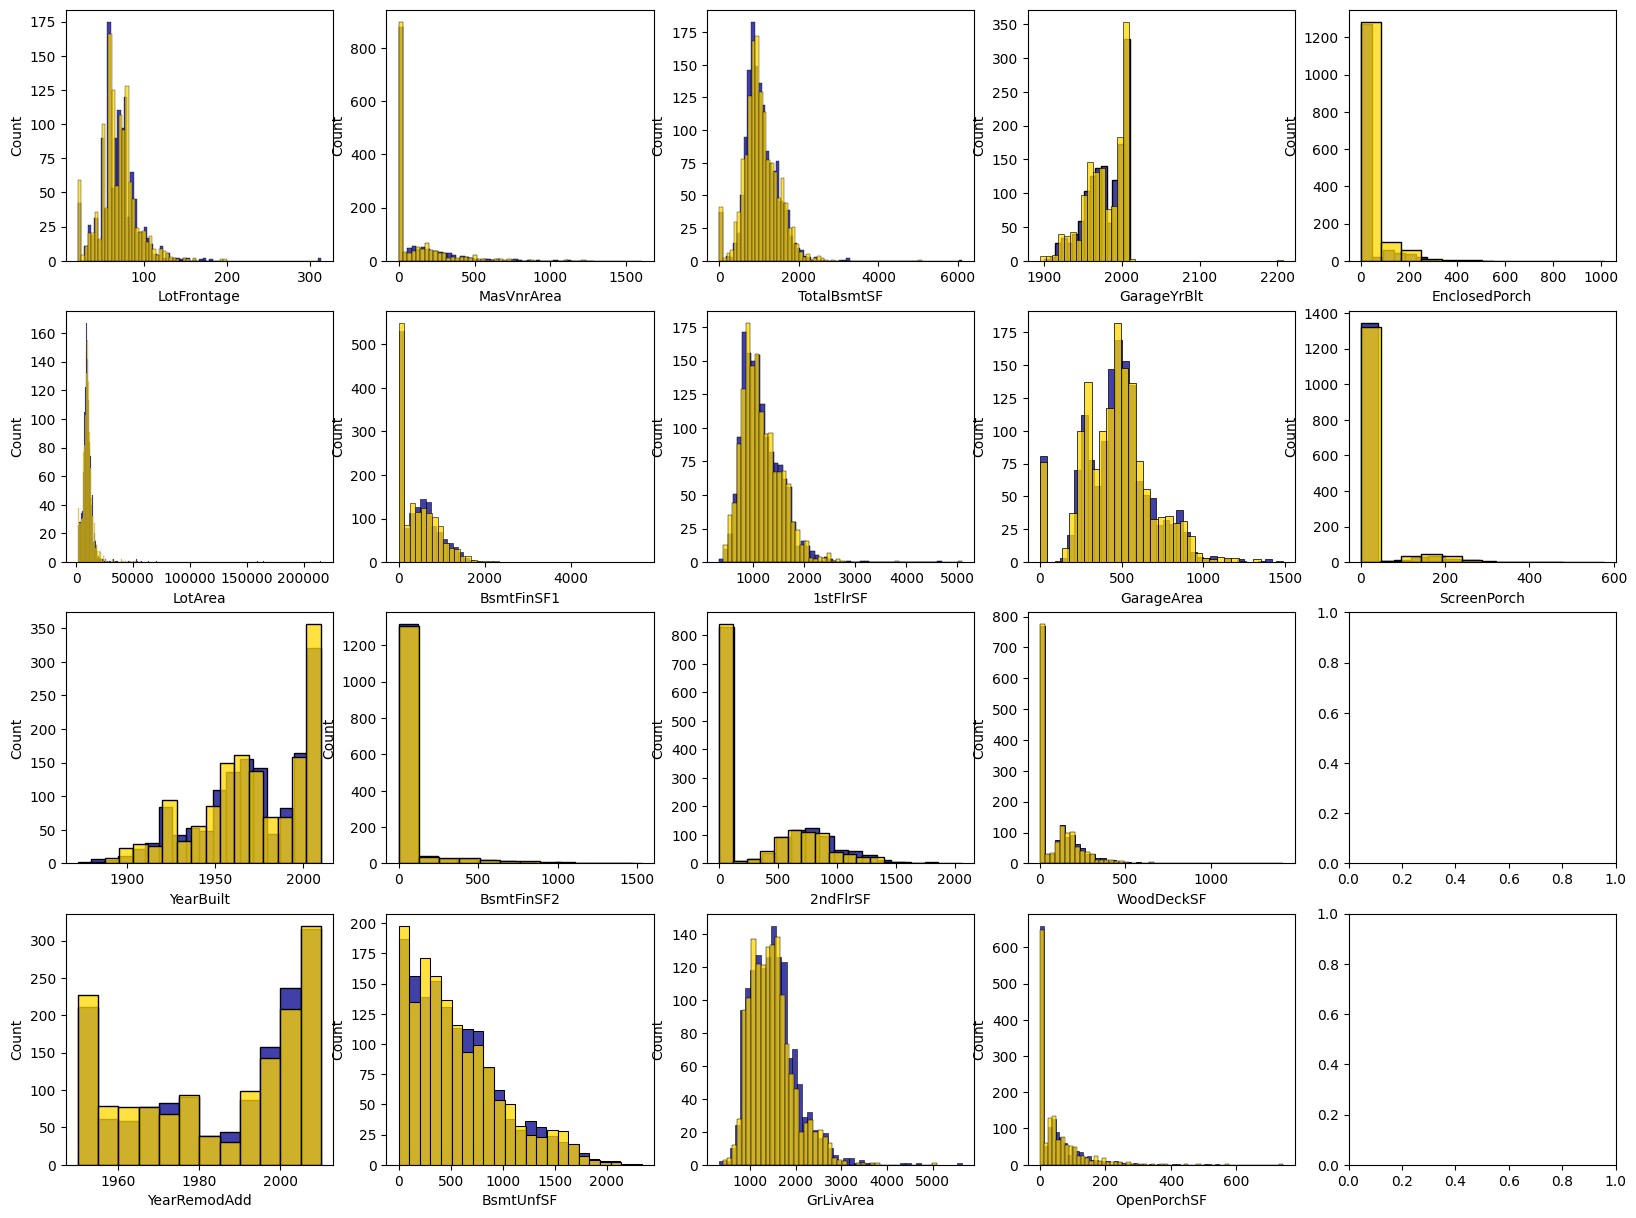

In [ ]:
fig , axes = plt.subplots(nrows=4, ncols=5, figsize=(20,15))

for i, feature in enumerate(continuous_feature):
    sns.histplot(data= train_data, x=feature, ax=axes[i%4, i//4], color='darkblue')
    sns.histplot(data= test_data,  x=feature, ax=axes[i%4,i//4],  color='gold')

plt.show()

Some features have a negative skewed distribution

###Skewness Detection

In [ ]:
skewness_train = train_data[numerical_feature].skew().sort_values(ascending=False)
skewness_test  = test_data[numerical_feature].skew().sort_values(ascending=False)

avg_skewness = (skewness_train + skewness_test) / 2
avg_skewness = avg_skewness.sort_values(ascending=False)

print(avg_skewness)

MiscVal         22.28
PoolArea        17.51
LowQualFinSF    12.59
3SsnPorch       11.41
LotArea          7.66
KitchenAbvGr     4.28
BsmtFinSF2       4.15
ScreenPorch      3.96
BsmtHalfBath     3.94
EnclosedPorch    3.88
MasVnrArea       2.60
OpenPorchSF      2.53
WoodDeckSF       1.84
1stFlrSF         1.47
BsmtFinSF1       1.43
LotFrontage      1.41
MSSubClass       1.38
GrLivArea        1.25
TotalBsmtSF      1.17
BsmtUnfSF        0.92
2ndFlrSF         0.86
TotRmsAbvGrd     0.76
Fireplaces       0.73
HalfBath         0.70
BsmtFullBath     0.62
OverallCond      0.57
BedroomAbvGr     0.32
GarageArea       0.24
OverallQual      0.20
MoSold           0.20
FullBath         0.17
YrSold           0.13
GarageCars      -0.22
GarageYrBlt     -0.40
YearRemodAdd    -0.45
YearBuilt       -0.60
dtype: float64


Any Skewness that more than 1 or lesser than -1, WIll be Transformed

###Main Datarow Checking

<Axes: xlabel='SalePrice', ylabel='Count'>

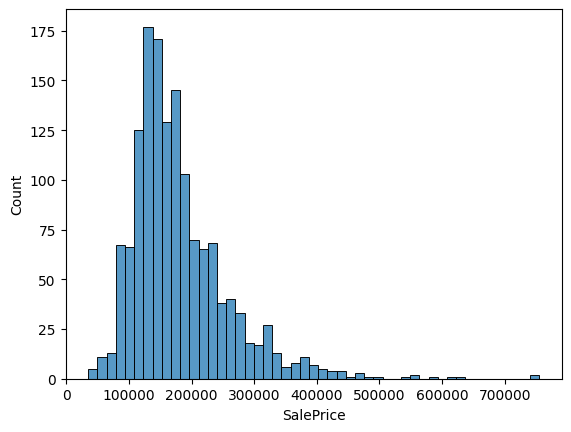

In [ ]:
sns.histplot(data=train_data, x='SalePrice')

###Correlation Comparison

<Axes: >

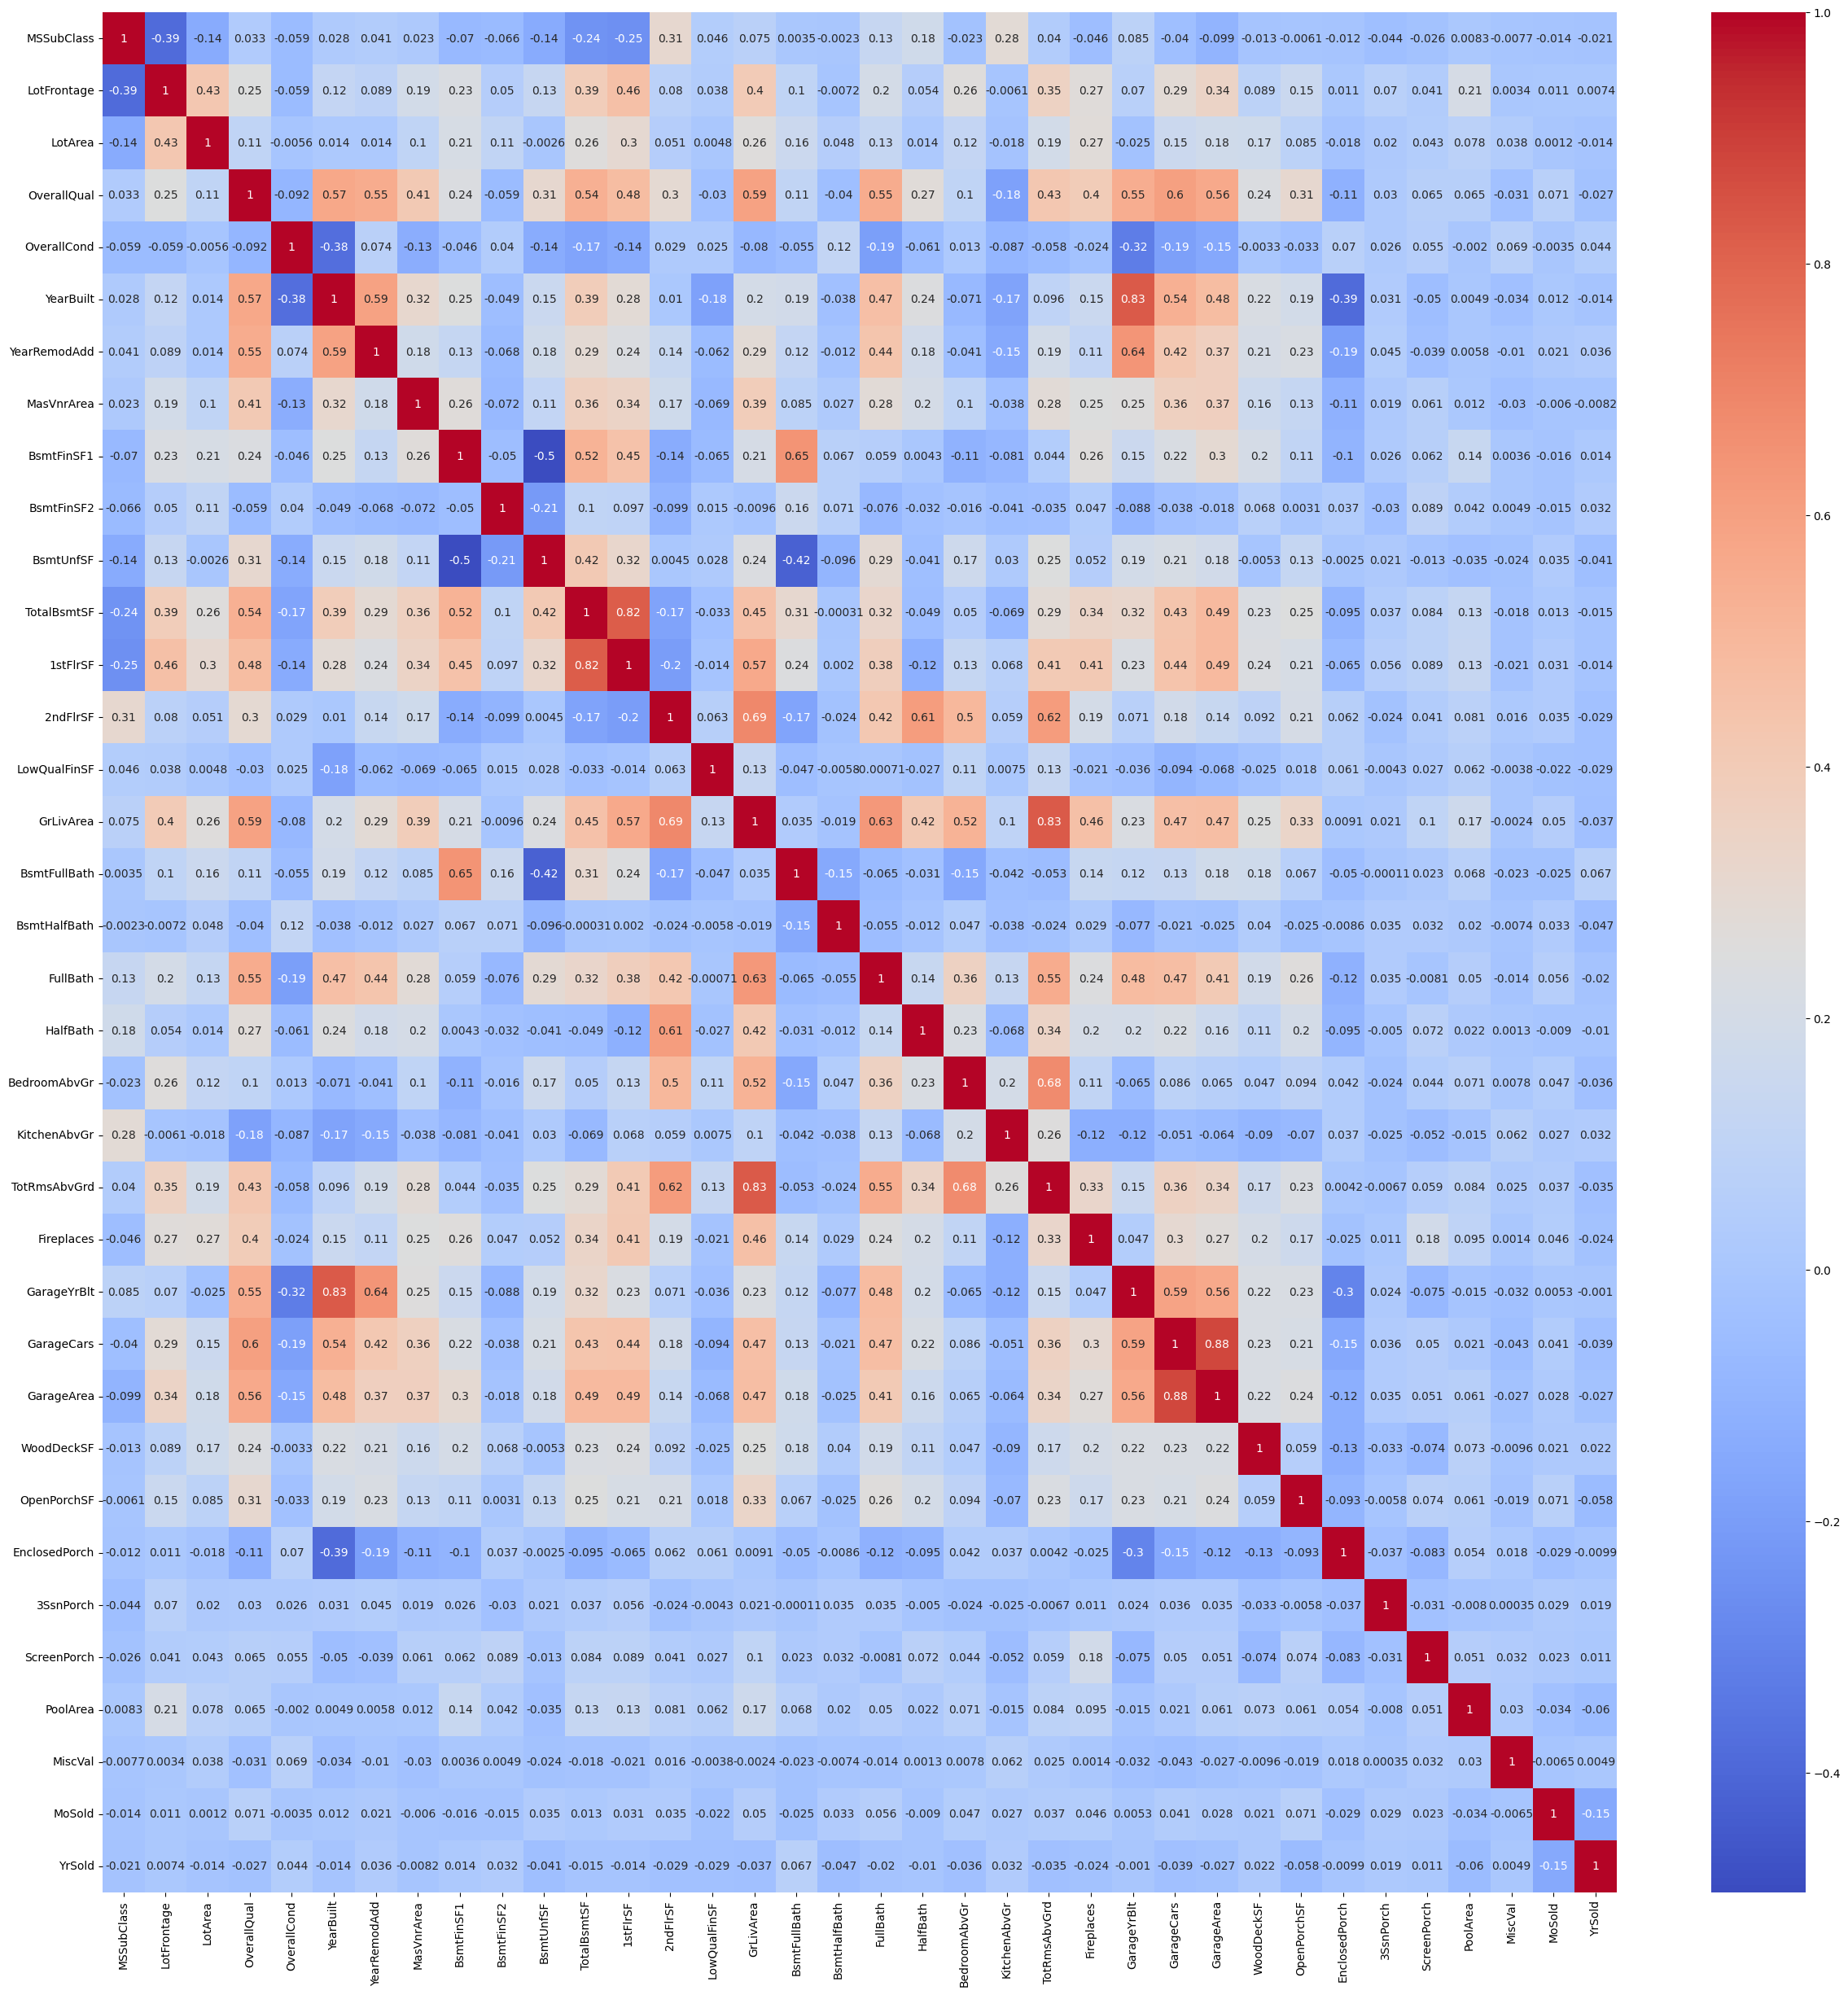

In [ ]:
# SET NUMERIC FEATURE
numeric_data = pd.DataFrame()

for feature in numerical_feature:
    numeric_data[feature] = train_data[feature]

corr_data = numeric_data.corr(method='pearson')

plt.figure(figsize=(30,30))
sns.heatmap(data= corr_data, cmap='coolwarm', annot=True, fmt='.2g')

Conclusion of correlation:

There is a strong correlation between:
- GarageArea and GarageCars.
- 1stFlrSF and TotalBsmtSF.
- GrLivArea and TotRmsAbvGrd.
We can consider removing one of them or using PCA to select the most important features

create new features such as:
- `df['GarageEfficiency'] = df['GarageArea'] / df['GarageCars']`
- `df['LivabilityScore'] = df['GrLivArea'] + (df['FullBath'] * 2) + (df['HalfBath'])`

###Correlation with Main Datarow

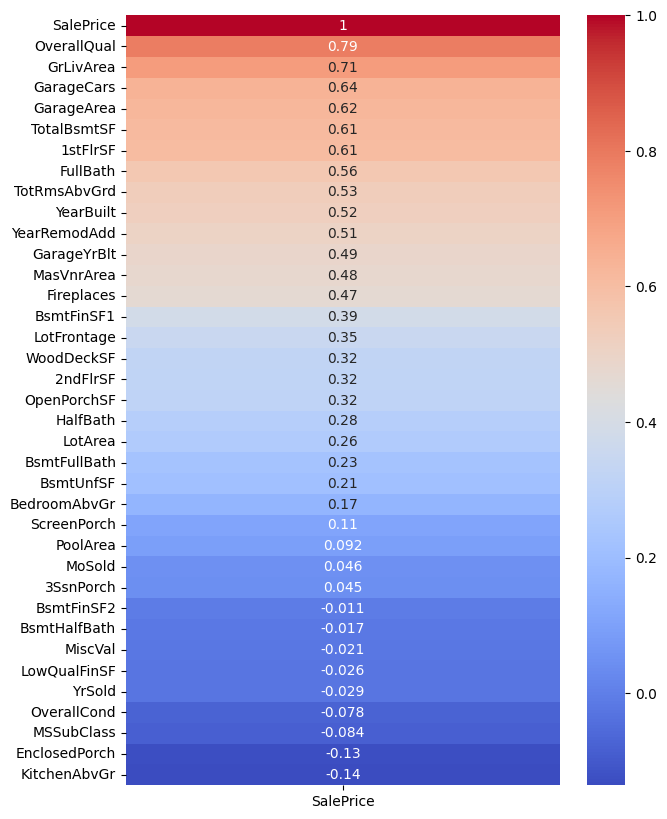

In [ ]:
numeric_data['SalePrice'] = train_data['SalePrice']  # ADD SALEPRICE COLUMN

# Calculate correlation matrix
corr_data = numeric_data.corr(method='pearson')

# Select correlations with SalePrice and order them
ordered_correlations = corr_data[['SalePrice']].sort_values(
    by='SalePrice', ascending=False
)

# Plot the heatmap
plt.figure(figsize=(7, 10))
sns.heatmap(data=ordered_correlations, cmap='coolwarm', annot=True, fmt='.2g')
plt.show()

These variables provide additional information that can help the model improve prediction accuracy, but are not as strong as the highly correlated variables.


create new feature TotalArea = `GrLivArea + TotalBsmtSF`: Adds the area of ​​living space and basement.

###Linearity Feature with Main Datarow

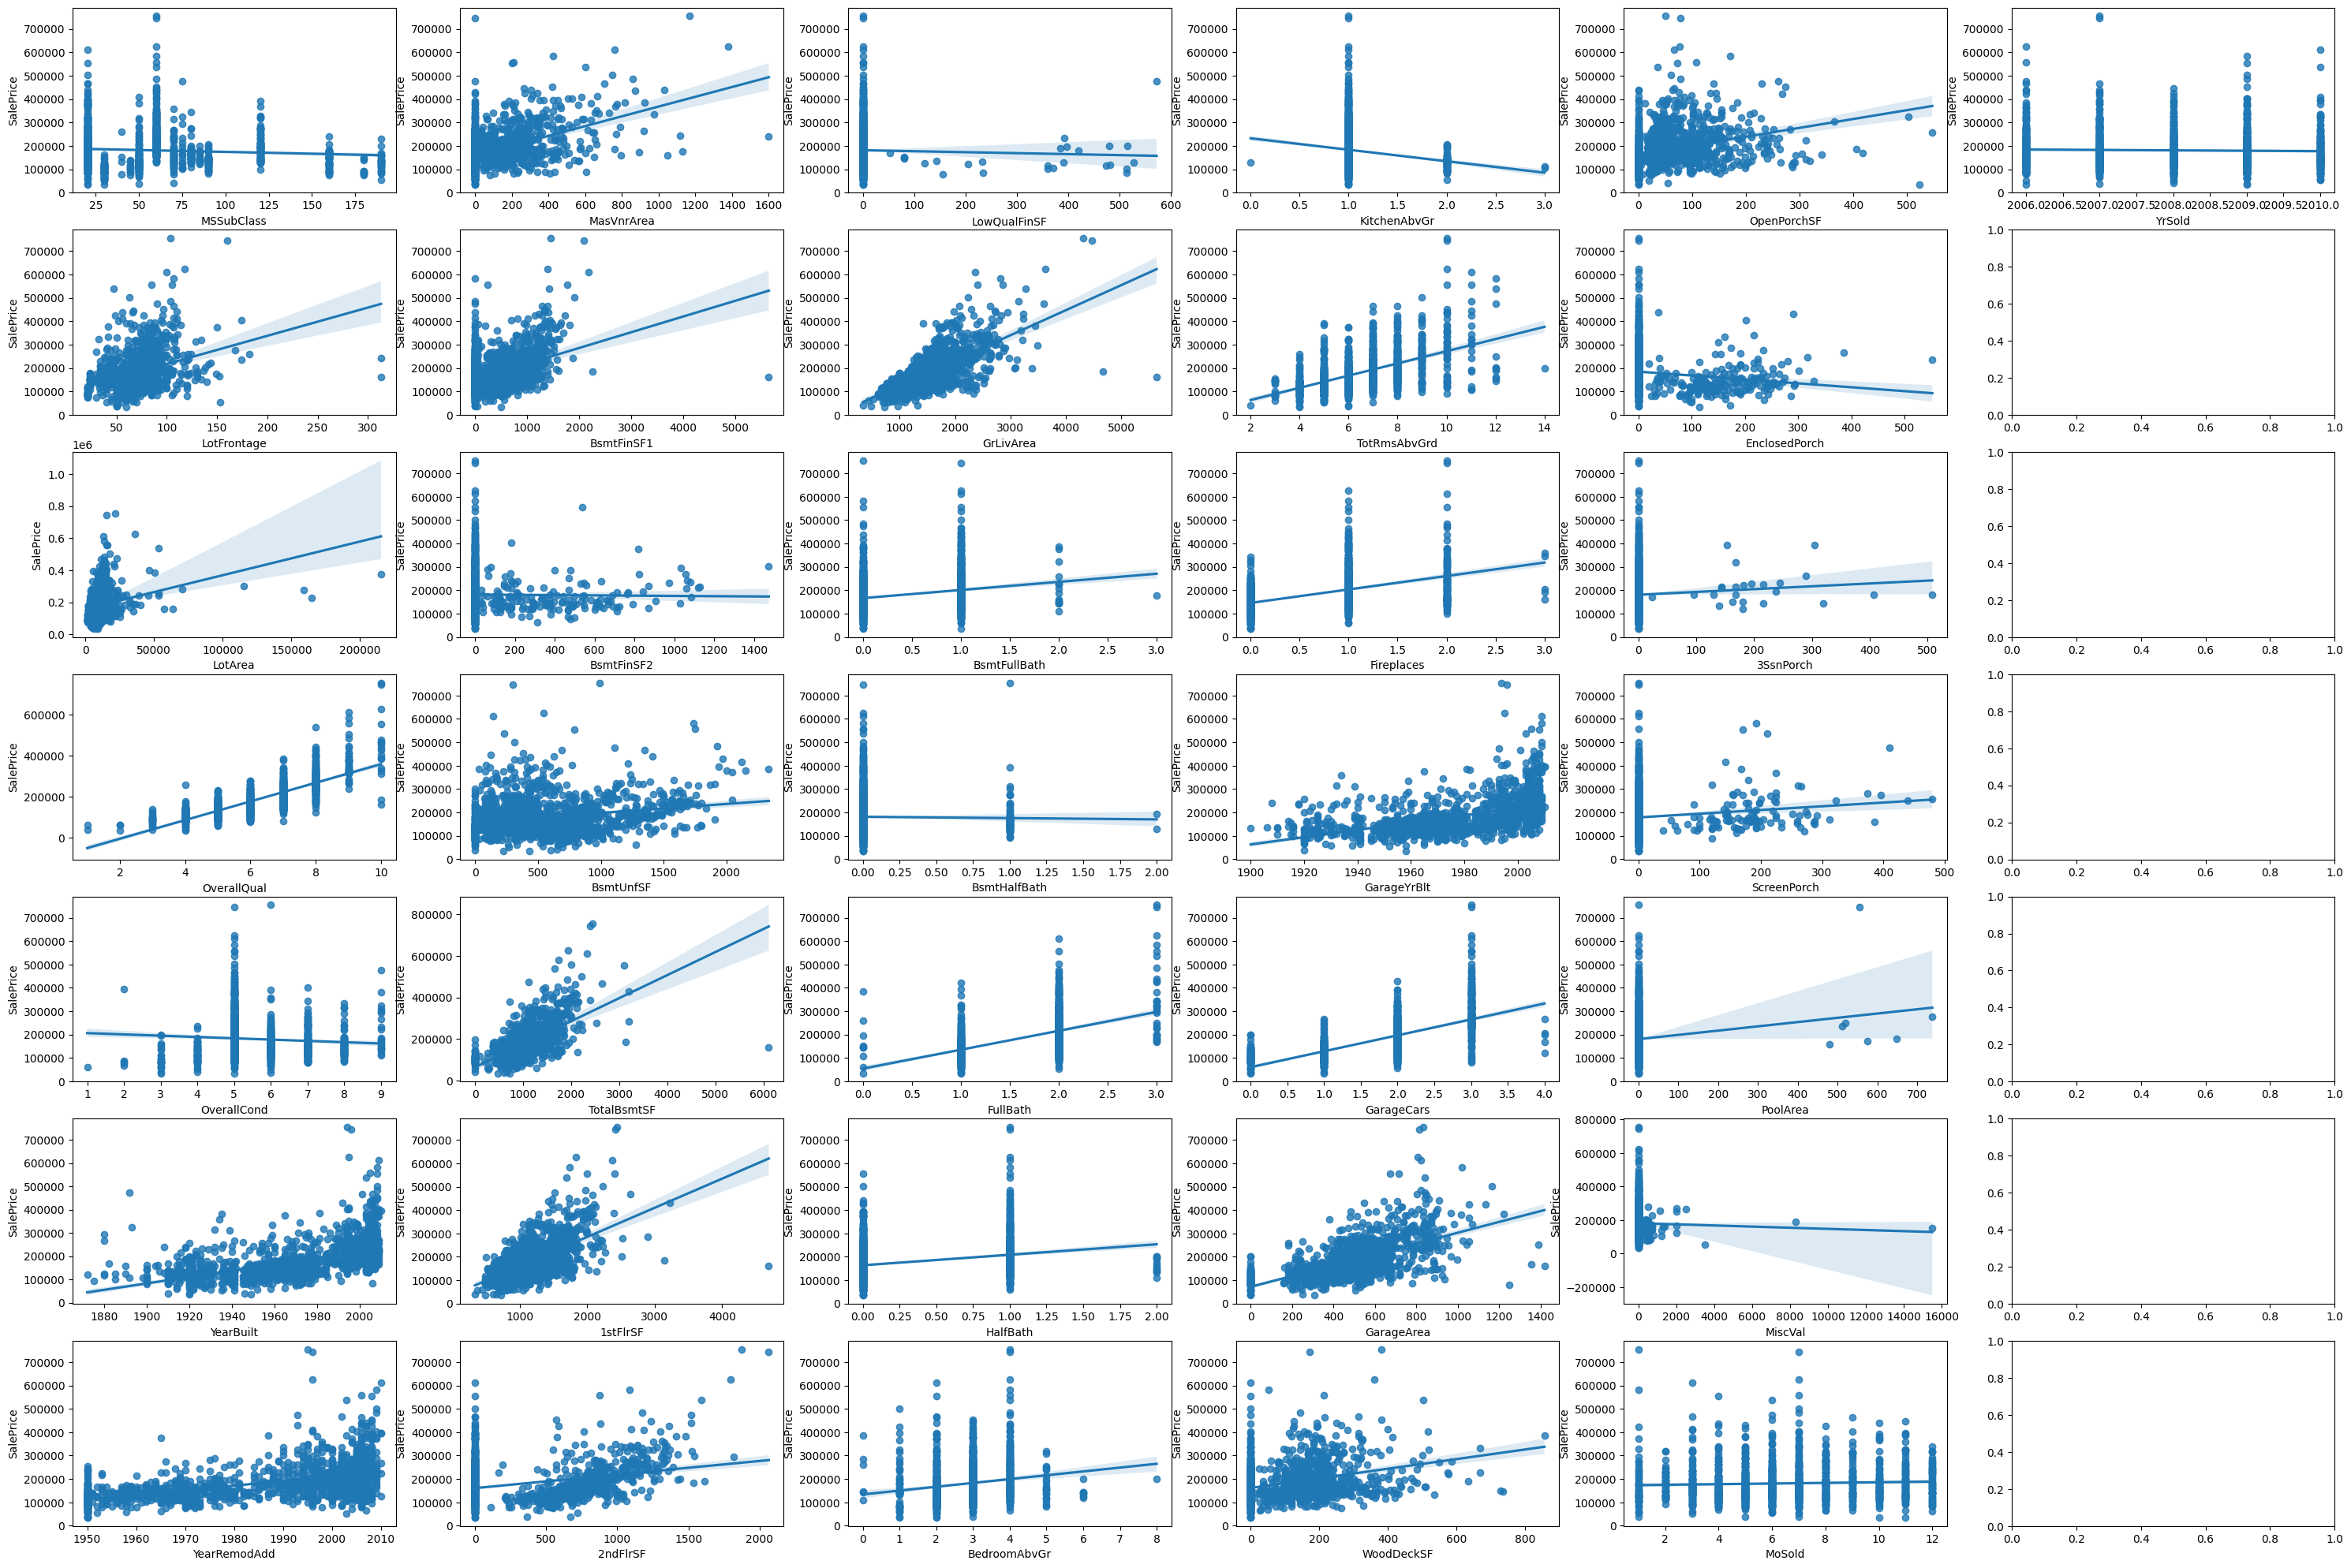

In [ ]:
fig , axes = plt.subplots(nrows=7, ncols=6, figsize=(37,25))

for i , feature in enumerate(numerical_feature):
    sns.regplot(data= train_data, x= feature, y= 'SalePrice', ax= axes[i%7, i//7])

plt.show()

From the data above, there are non-linear relationships such as:
- GrLivArea and SalePrice,
- BsmtFinSF1 and SalePrice,
- TotalBsmtSF and SalePrice,
- LotFrontage and SalePrice,
- LotArea and SalePrice,
- GarageArea and SalePrice

###Experimental Data Correlation with Main Datarow

Text(0.5, 1.0, 'House price vs YearSold')

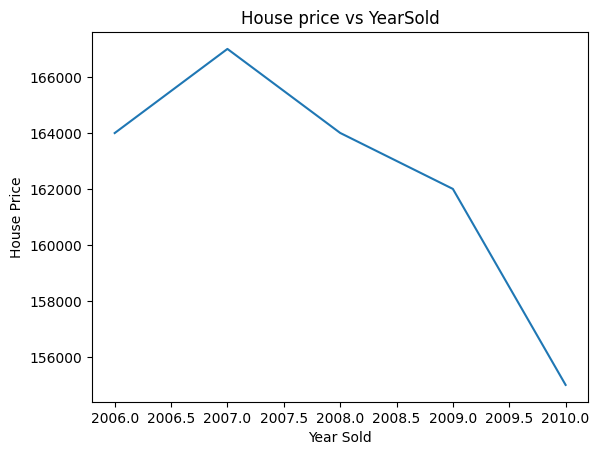

In [ ]:
combined_data.groupby('YrSold')['SalePrice'].median().plot()
plt.xlabel('Year Sold')
plt.ylabel('House Price')
plt.title('House price vs YearSold')

There is a negative correlation between YrSold and SalePrice. This means that YrSold has an effect on SalePrice.

#Feature Engineering

##Column Dropping

In [ ]:
# First Drop Columns with Many Null Values
cols_with_many_null = ['PoolQC', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']
combined_data.drop(labels=cols_with_many_null, axis=1, inplace=True)

# NEXT Drop Columns with Many Zero Values
cols_with_many_zero = ['LowQualFinSF', 'MiscVal', '3SsnPorch', 'PoolArea']
combined_data.drop(labels=cols_with_many_zero, axis=1, inplace=True)

# LAST Drop Columns with Dominant 1 Label
cols_with_dominant_label = ['Id','RoofMatl', 'Street', 'Condition2', 'Utilities', 'Heating']
combined_data.drop(labels=cols_with_dominant_label, axis=1, inplace=True)

combined_data.columns  , len(combined_data.columns)   # Check Final Columns After Dropped

##Temporal Variable

In [ ]:
# FIND ALL DATE FEATURE
year_feature = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

for feature in year_feature:
    combined_data[feature] = combined_data['YrSold'] - combined_data[feature]

combined_data[year_feature].head(5)

##Fill Missing Values

In [ ]:
# FILL Numerical Missing Values with Zero Values
numerical_feature = combined_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
for feature in numerical_feature:
    combined_data[feature] = combined_data[feature].fillna(0)

# FILL Continous Missing Values
dropped_cols = cols_with_dominant_label + cols_with_many_null
mode_feature = ['Electrical', 'MsZoning', 'Functional', 'KitchenQual', 'Exterior2nd', 'Exterior1st', 'Utilities', 'SaleType']


for feature in categorical_feature:
    if feature not in dropped_cols:
        if feature not in mode_feature:
            combined_data[feature] = combined_data[feature].fillna('Unknown')
        else:
            combined_data[feature] = combined_data[feature].fillna(combined_data[feature].mode()[0])-

In [ ]:
combined_data.info()

##Combining Variables and Create new Feature

In [ ]:
# Add New Feature 'GarageEfficiency'
combined_data['GarageEfficiency'] = combined_data['GarageArea'] / (combined_data['GarageCars'] + 1)   # +1 TO AVOID DIVISION BY ZERO

# Add New Feature
#combined_data['LivabilityScore'] = combined_data['GrLivArea'] + (combined_data['FullBath'] * 2) + (combined_data['HalfBath'])

# Add New Feature TotalArea
combined_data['TotalArea'] = combined_data['GrLivArea'] + combined_data['TotalBsmtSF']

In [ ]:
combined_data[['GarageEfficiency', 'TotalArea']].head(5)

##Solving Multi-Correlationality

In [ ]:
# Using PCA to address Multicolinearity


zscore = StandardScaler()

# Normalization
multi_cols_1 = combined_data[['GarageArea','GarageCars']]   # Multicolinearity Column
multi_cols_1 = zscore.fit_transform(multi_cols_1)

# Find Principal Component Optimal
pca_1  = PCA(n_components=None)
pca_1.fit_transform(multi_cols_1)


# Normalization
multi_cols_2 = combined_data[['1stFlrSF', 'TotalBsmtSF']]
multi_cols_2 = zscore.fit_transform(multi_cols_2)

# Find Principal Component Optimal
pca_2  = PCA(n_components=None)
pca_2.fit_transform(multi_cols_2)


# Normalization
multi_cols_3 = combined_data[['GrLivArea', 'TotRmsAbvGrd']]
multi_cols_3 = zscore.fit_transform(multi_cols_3)

# Find Principal Component Optimal
pca_3  = PCA(n_components=None)
pca_3.fit_transform(multi_cols_3)

for pca in [pca_1, pca_2, pca_3]:
    print(f'Number of Components : {pca.n_components_}')
    print(f'Ratio every Component / PC : {pca.explained_variance_ratio_}\n')
    print(f'PCA Components : \n{pca.components_}\n')
    print('---------------------------------')

PCA 1 Having the Most highest Ratio of all three, so we pick PC 1

In [ ]:
# CHOOSE PC1

pca_1  = PCA(n_components=1)
multi_cols_1 = pca_1.fit_transform(multi_cols_1)

pca_2  = PCA(n_components=1)
multi_cols_2 = pca_2.fit_transform(multi_cols_2)

pca_3  = PCA(n_components=1)
multi_cols_3 = pca_3.fit_transform(multi_cols_3)

# ADD PC1 TO DATAFRAME
combined_data['multi_cols_1'] = multi_cols_1.ravel()
combined_data['multi_cols_2'] = multi_cols_2.ravel()
combined_data['multi_cols_3'] = multi_cols_3.ravel()

In [ ]:
combined_data.head(5)

####Heat-Map Rechecking

In [ ]:
multi = combined_data[['SalePrice', 'multi_cols_1','GarageCars','GarageArea', 'multi_cols_2','1stFlrSF', 'TotalBsmtSF', 'multi_cols_3', 'GrLivArea', 'TotRmsAbvGrd']]

multiq = multi.corr(method='spearman')

sns.heatmap(data=multiq, annot=True, fmt='.2g')

###Drop Multicolinearity Feature

In [ ]:
multi_corr = ['GarageCars','GarageArea','1stFlrSF', 'TotalBsmtSF','GrLivArea', 'TotRmsAbvGrd']

combined_data.drop(labels= multi_corr, axis=1, inplace=True )

combined_data.head(5)

###Feature-Transformation

For Skewness Transformation (> 1 or < -1)

In [ ]:
# SELECT ALL NUMERICAL DATA
transform_data      = combined_data.select_dtypes(include=['int64', 'float64'])
continuous_feature  = [col for col in transform_data if len(transform_data[col].unique()) > 25]    # SELECT ONLY CONTINUOUS FEATURE
transform_data = combined_data[continuous_feature]
transform_data.drop(labels=['SalePrice'], axis=1 , inplace=True)

# CHECK SKEWNESS
skewness = transform_data.skew().sort_values(ascending=False)

# APPLY TRANSFORM FOR FEATURE HAVE SKEWNESS > 1 OR < -1
# cols_to_transform = skewness[(skewness > 1) | (skewness < -1)].index
cols_to_transform = ['LotArea', 'TotalArea', 'TotalArea', 'multi_cols_2', 'BsmtUnfSF']  # CHOSEN FEATURE TO TRANSFORM

for col in cols_to_transform:
    yeo_johnson = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
    combined_data[[col]] = yeo_johnson.fit_transform(combined_data[[col]])

Then Visualize

In [ ]:
fig , axes = plt.subplots(nrows=1, ncols=5, figsize=(14,4))

for i , feature in enumerate(cols_to_transform):
    sns.histplot(data=combined_data, x=feature, ax=axes[i%5])

plt.show()

##One-Hot Encoder

In [ ]:
combined_data = pd.get_dummies(combined_data).reset_index(drop=True)

combined_data

In [ ]:
new_train_data = combined_data.iloc[:len(train_data), :]
new_test_data  = combined_data.iloc[len(train_data):, :]

x_train = new_train_data.drop(labels=['SalePrice'], axis=1)

# Log Transformation For Target Feature (SalePrice)
y_train = np.log1p(new_train_data['SalePrice'])

x_test = new_test_data.drop(labels=['SalePrice'], axis=1)


x_train.shape , y_train.shape, x_test.shape

###Re-Split Combined Dataset

In [ ]:
new_train_data = combined_data.iloc[:len(train_data), :]
new_test_data  = combined_data.iloc[len(train_data):, :]

x_train = new_train_data.drop(labels=['SalePrice'], axis=1)

# LOG TRANSFORMATION FOR TARGET FEATURE (SalePrice)
y_train = np.log1p(new_train_data['SalePrice'])

x_test = new_test_data.drop(labels=['SalePrice'], axis=1)


x_train.shape , y_train.shape, x_test.shape

##Feature Scaling
Before we do normalization , Let's take a look again at the Data Distribution

In [ ]:
# Select All Numerical Feature
numerical_feature = ['MSSubClass','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','2ndFlrSF','BsmtFullBath',
                     'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','Fireplaces','GarageYrBlt','WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch',
                     'MoSold','YrSold','GarageEfficiency','TotalArea','multi_cols_1','multi_cols_2','multi_cols_3']


# Vizualize
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(25,20))
for i , feature in enumerate(numerical_feature):
    sns.histplot(data= x_train , x=feature , ax=axes[i%5, i//5])

# Boxplot
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(25,20))
for i,feature in enumerate(numerical_feature):
    sns.boxplot(data=x_train, x=feature, ax=axes[i%5, i//5])

plt.show()

We will perform robust scaling normalization for features that have many outliers and are not normally distributed. and use zscore normalization for features that are almost normally distributed.

In [ ]:
# Normalization

# Choose Column to be Normalized
cols_to_robust = ['MSSubClass','YearRemodAdd', '2ndFlrSF','BedroomAbvGr','OpenPorchSF','MasVnrArea','EnclosedPorch','BsmtFinSF1','ScreenPorch','BsmtFinSF2','GarageYrBlt','YearBuilt','WoodDeckSF']
cols_to_zscore = ['GarageEfficiency','LotArea','TotalArea','OverallQual','multi_cols_1','OverallCond','multi_cols_2','BsmtUnfSF','multi_cols_3']

# Robust Scaling Norm
robust = RobustScaler()
robust.fit(x_train[cols_to_robust])

x_train[cols_to_robust] = robust.transform(x_train[cols_to_robust])
x_test[cols_to_robust]  = robust.transform(x_test[cols_to_robust])

# Zscore Norm
zscore = StandardScaler()
zscore.fit(x_train[cols_to_zscore])

x_train[cols_to_zscore] = zscore.transform(x_train[cols_to_zscore])
x_test[cols_to_zscore]  = zscore.transform(x_test[cols_to_zscore])

x_train.shape , x_test.shape